# VQE for LiH molecule 

Simulate LiH molecule using the STO-3G basis with the PySCF driver.
- using FreezeCoreTransformer to freeze core elctrons.
- using Parity with two_qubit_reduction=True to eliminate 2 qubits.
- using `Z2Symmetries` to reduce the number of qubits by inspecting the symmetries of our Hamiltonian.

In [11]:
from qiskit_nature.drivers.second_quantization import PySCFDriver

# molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
molecule = 'O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0'
# molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [12]:
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

# freezeCoreTransformer = FreezeCoreTransformer(freeze_core=True,remove_orbitals=[3, 4])
# qmolecule = freezeCoreTransformer.transform(qmolecule)

In [13]:
print(qmolecule)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.994129744428358
		[0, 1] = -0.23278942745893805
		[0, 2] = -1.9724914427301742e-17
		[0, 3] = 0.10317496214803933
		[0, 4] = 3.301658495628743e-31
		[0, 5] = -0.13237247995873644
		[0, 6] = -1.1219872106338594e-16
		[1, 0] = 0.026559931272198065
		[1, 1] = 0.833530123448932
		[1, 2] = 3.847997354031418e-16
		[1, 3] = -0.536847756318672
		[1, 4] = -1.5905197405344334e-30
		[1, 5] = 0.8845506617185602
		[1, 6] = 4.529796904720847e-16
		[2, 0] = -7.803590417582807e-19
		[2, 1] = 2.435851097279134e-16
		[2, 2] = 0.6064492828850188
		[2, 3] = 1.2223802593545332e-15
		[2, 4] = -6.16843200

In [44]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
# problem = ElectronicStructureProblem(driver)
problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True,remove_orbitals=[3, 4])])
# problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])
# problem = ElectronicStructureProblem(driver,q_molecule_transformers=[ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=4, 
#                                                 active_orbitals=[1,2,3,4])])


# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

In [29]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction = [-1,1])
# converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction = [1,-1,1])

# The fermionic operators are mapped to qubit operators
num_particles = problem.num_particles
qubit_op = converter.convert(main_op, num_particles=num_particles)

In [30]:
print(qubit_op.num_qubits)
print(qubit_op)

8
-18.81377615455913 * IIIIIIII
+ 1.1688653458870422 * ZIIZZZIZ
- 9.563877467755333e-14 * IZZIIIZI
- 0.1378423795531069 * ZZZZZZZZ
+ 0.0032598932880351927 * IIIIIIIX
+ 0.06057755287137647 * IZZIIIZX
+ 0.06057755287137645 * ZIIZZZIX
+ 0.0032598932880355046 * ZZZZZZZX
- 0.13899475469066624 * IIIIIZXX
- 0.13899475469066624 * ZIIZZZYY
+ 0.12519187368957468 * IIIIIIIZ
+ 0.8131613222582165 * ZIIZZZII
- 0.8227931940302188 * IZZIIIZZ
- 0.13791764565770753 * ZZZZZZZI
- 0.02448579621609426 * IIIIIXXX
+ 0.19168808260198217 * ZIIZZYXY
- 0.19168808260198142 * IIIIIYXY
+ 0.024485796216093165 * ZIIZZXXX
- 0.11369424413595315 * IIIIIZXZ
- 0.01860726861250849 * ZIIZZIXI
- 0.11369424413595315 * IZZIIIXI
- 0.01860726861250849 * ZZZZZZXZ
+ 0.11275399427598984 * IIIIIIZI
+ 0.03611298168943683 * ZZZZZZIZ
+ 0.3854230117318317 * IIIIIZZI
+ 0.1280723515380925 * ZIIZZIZZ
+ 0.006087544377145877 * IZZIIZII
+ 0.3769723335135001 * IIIIIZII
+ 0.14059934734014973 * ZIIZZIIZ
+ 0.009651235609047789 * IZZIIZZI
+ 1.16886

In [40]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
# print(result_exact)

# The targeted electronic energy for LiH is -8.908697 Ha
# Check with your VQE result.

Exact electronic energy -23.146123480571983


In [48]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = problem.num_particles
num_spin_orbitals = problem.num_spin_orbitals
# num_spin_orbitals = problem.num_spin_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

          
q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────
     ┌───┐
q_5: ┤ X ├
     └───┘
q_6: ─────
          
q_7: ─────
          


In [51]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import QuantumCircuit

# Choose the ansatz
ansatz_type = "Custom"

# Parameters for q-UCC antatze
num_particles = problem.num_particles
num_spin_orbitals = problem.num_spin_orbitals


# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
#     rotation_blocks = ['ry','rx','rz']
    rotation_blocks = ['rz','ry','rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
#     entanglement = 'full'
    entanglement = 'linear'
#     entanglement = [[0,1],[1,2],[2,3]]
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
#     ansatz = QuantumCircuit(6)
#     for i in range(6):
#         ansatz.h(i)

    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer, insert_barriers=True)
#     tmp = QuantumCircuit(4)
#     tmp.cx(3,0)
#     ansatz.compose(tmp, inplace=True)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    a = Parameter('a')
    b = Parameter('b')
    c = Parameter('c')
    d = Parameter('d')
    e = Parameter('e')
    f = Parameter('f')
    g = Parameter('g')
    h = Parameter('h')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Visual separator
    qc.barrier()
    qc.ry(a, 0)
    qc.ry(b, 1)
    qc.ry(c, 2)
    qc.ry(d, 3)
    for i in range(1):
        qc.h(i)
#     qc.rz(e, 0)
#     qc.rz(f, 1)
#     qc.rz(g, 2)
#     qc.rz(h, 3)
    qc.cx(0,1)
    qc.cx(0,2)
    qc.cx(0,3)
#     qc.ry(a, 0)
#     qc.ry(b, 1)
#     qc.ry(c, 2)
#     qc.ry(d, 3)
    qc.barrier()
    qc.ry(e, 0)
    qc.ry(f, 1)
    qc.ry(g, 2)
    qc.ry(h, 3)

    
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

# ansatz.draw()
print(ansatz)

           ░ ┌───────┐┌───┐                ░ ┌───────┐
q_0: ──────░─┤ Ry(a) ├┤ H ├──■────■────■───░─┤ Ry(e) ├
           ░ ├───────┤└───┘┌─┴─┐  │    │   ░ ├───────┤
q_1: ──────░─┤ Ry(b) ├─────┤ X ├──┼────┼───░─┤ Ry(f) ├
     ┌───┐ ░ ├───────┤     └───┘┌─┴─┐  │   ░ ├───────┤
q_2: ┤ X ├─░─┤ Ry(c) ├──────────┤ X ├──┼───░─┤ Ry(g) ├
     └───┘ ░ ├───────┤          └───┘┌─┴─┐ ░ ├───────┤
q_3: ──────░─┤ Ry(d) ├───────────────┤ X ├─░─┤ Ry(h) ├
           ░ └───────┘               └───┘ ░ └───────┘
q_4: ──────░───────────────────────────────░──────────
     ┌───┐ ░                               ░          
q_5: ┤ X ├─░───────────────────────────────░──────────
     └───┘ ░                               ░          
q_6: ──────░───────────────────────────────░──────────
           ░                               ░          
q_7: ──────░───────────────────────────────░──────────
           ░                               ░          


In [52]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

In [54]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=2000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

In [55]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 213,
    'eigenstate': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+0

In [56]:
print(result.eigenvalue)
print(np.around(result.eigenstate, 5))

(-22.196984741125856+0j)
[ 0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00-0.j -0.0e+00-0.j -2.3e-04+0.j
 -0.0e+00+0.j  1.0e-05-0.j  8.0e-05-0.j -8.9e-04+0.j -0.0e+00+0.j
 -0.0e+00+0.j  1.0e-05+0.j  3.0e-05-0.j  0.0e+00-0.j  2.0e-05+0.j
 -1.0e+00+0.j  1.1e-04-0.j  3.0e-05-0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j
  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,QuantumCircuit,8,8,None,None,None,None,949.138739,False,3


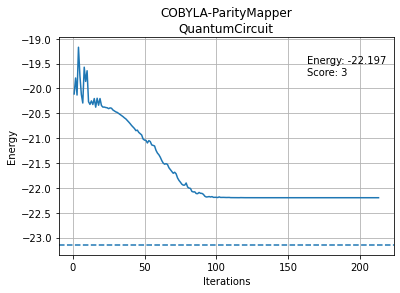

In [57]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_lih.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer', 'ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]